# Parsing 'Results*' Files

This section will be used to parse the results file in `data/` and create a csv with the required outputs.

In [1]:
import glob
import pandas as pd
from bs4 import BeautifulSoup


In [20]:
def get_attr_from_tag(content, attribute:str)->str:
    if isinstance(content, str):
        tag = BeautifulSoup(content, 'html.parser').b
    else:
        tag = content
    return tag[attribute]

def clean_title(title:str)->str:
    cleaned = title.replace('&amp;', '&')
    return cleaned

def get_date_from_tag(content)->str:
    attr_val = get_attr_from_tag(content, attribute='href')
    date = attr_val.split('/')[1]
    return date

def get_url_from_tag(content)->str:
    attr_val = get_attr_from_tag(content, attribute='href')
    local_path = attr_val
    url = 'https://sputnikglobe.com' + local_path
    return url

def get_title_from_tag(content)->str:
    attr_val = get_attr_from_tag(content, attribute='title')
    title = clean_title(attr_val)
    return title

In [11]:
results_paths = glob.glob(pathname='../data/results_*.txt')

In [22]:
data_dict = {'date':[], 'url':[], 'title':[]}
for result_path in results_paths:
    with open(file=result_path, mode='r', encoding='utf-8') as f:
        soup = BeautifulSoup(f.read())
    results = soup.find_all(name='a', attrs={'href':True, 'title':True, 'class':False})
    for result in results:
        data_dict['date'].append(get_date_from_tag(result))
        data_dict['url'].append(get_url_from_tag(result))
        data_dict['title'].append(get_title_from_tag(result))
df = pd.DataFrame(data_dict)

In [25]:
print(df.shape[0])
df.tail()

4503


,date,url,title
4498,20210901,https://sputnikglobe.com/20210901/senior-fda-v...,Senior FDA Vaccine Officials Resign Amid Repor...
4499,20210901,https://sputnikglobe.com/20210901/indian-state...,Indian State Orders Probe as Spreading 'Myster...
4500,20210901,https://sputnikglobe.com/20210901/israeli-stat...,Israeli State Comptroller Slams Netanyahu's CO...
4501,20210901,https://sputnikglobe.com/20210901/norway-sees-...,Norway Sees Record COVID-19 Infection Rates De...
4502,20210901,https://sputnikglobe.com/20210901/live-updates...,Live Updates: Ireland to Lift Most COVID-19 Re...


In [26]:
df.to_csv('../data/results_sputnikglobe_20201201_20211130.csv')

# Scraping Content from Results

This section will be used to parse the results file in `data/` and create a csv with the required outputs.

In [ ]:
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException, WebDriverException
import numpy as np
import time

## Sputnik Globe

In [49]:
# Get urls
df = pd.read_csv('../data/results_sputnikglobe_20201201_20211130.csv')

# Set sleep times
mu, sigma = 0.5, 1. # mean and standard deviation
s = np.random.lognormal(mu, sigma, df.shape[0])

In [60]:
text = []
pull_time = []
keywords = []
analytics_keywords = []

# Initialize driver
driver = webdriver.Firefox()

# on by one, visit site, pull source, and store tags of interest
for i, row in enumerate(['https://sputnikglobe.com/20210430/albania-approves-use-of-russian-covid-19-vaccine-sputnik-v-1082773076.html']):#enumerate(df['url']):
    pull_time.append(time.strftime('%Y-%m-%dT%H:%M:%S', time.gmtime()))
    try:
        driver.get(row)
    except WebDriverException as e:
        text.append(f'[ERROR] The url is not reachable at this time.')
        keywords.append(f'[ERROR] The url is not reachable at this time.')
        analytics_keywords.append(f'[ERROR] The url is not reachable at this time.')
        continue
    soup = BeautifulSoup(driver.page_source)
    url_keywords = soup.find(name='meta', attrs={'name':'keywords'})
    keywords.append(url_keywords['content'])
    url_analytics_keywords = soup.find(name='meta', attrs={'name':'analytics:keyw'})
    analytics_keywords.append(url_analytics_keywords['content'])
    text_header = soup.find(name='div', attrs={'class':'article__announce-text'})
    text_body = soup.find(name='div', attrs={'class':'article__body'})
    text.append(text_header.text + text_body.text)
    if i%200 == 0:
        print(f'{i/df.shape[0]}% completed...')
    time.sleep(s[i])
    break
driver.quit()

# Add rows to dataframe
if len(text) == df.shape[0]:
    df['text'] = text
    df['pull_time'] = pull_time
    df['keywords'] = keywords
    df['analytics_keywords'] = analytics_keywords
else:
    print('[WARNING] Some text was not pulled')

0.0% completed...
[WARNING] Some text was not pulled


In [65]:
analytics_keywords

['news, world, tag_RussianDirectInvestmentFundRDIF, geo_Russia, tag_Albania, keyword_vaccination, covid-19, sputnik-v']

analytics = '''<meta name="analytics:keyw" content="military, news, tag_JoeBiden, organization_US_military">'''
keywords = '''<meta name="keywords" content="military &amp; intelligence, newsfeed, joe biden, us military">'''
google_tags = '''<script type="text/javascript" id="" charset="">ym(google_tag_manager["rm"]["11997873"](44),"params",{tags:{1082775132:["Military \x26 Intelligence, Newsfeed, Joe Biden, US military, COVID-19, Vaccines, US soldiers, mandate"]}});</script>'''

In [45]:
with open('../data/sputnik_example_1.txt', mode='r', encoding='utf-8') as f:
    soup = BeautifulSoup(f.read())

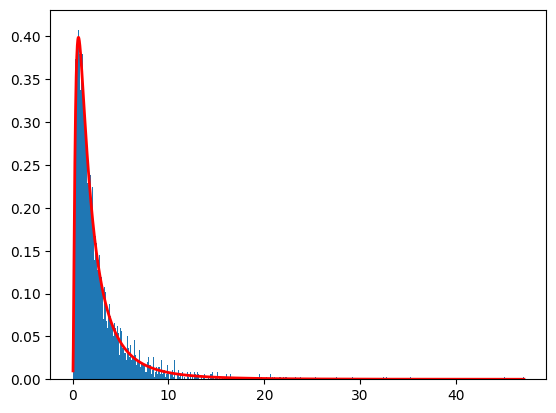

In [ ]:
import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, 600, density=True, align='mid')

x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

In [14]:
s[:10]

array([ 32.01978844, 108.84172139,  18.93182656,  10.0176788 ,
        17.00597689,   8.75356768,   5.75493506,  19.45755798,
        12.43707248,  67.11591437])

Weird-looking urls: 
- [text in a box](https://sputnikglobe.com/20210825/live-updates-16-evacuees-from-afghanistan-test-positive-for-covid-19-in-india-as-delta-cases-rise-1083705747.html)
- [multiple texts in box](https://sputnikglobe.com/20210824/live-updates-india-covid-19-cases-rise-to-3247-million-1083697851.html)
- [tweets](https://sputnikglobe.com/20210823/seven-members-of-dalit-family-in-india-severely-beaten-over-black-magic-allegation-1083692603.html)